# Explaining Titanic model using SHAP

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

import shap
shap.initjs()

from sklearn.metrics import classification_report
import keras
import tensorflow as tf

from scipy.special import expit as sigmoid

Using TensorFlow backend.


# Simple feature engineering
Download the data from [https://www.kaggle.com/c/titanic/data](https://www.kaggle.com/c/titanic/data) and place it in the data folder where this notebook is.

In [2]:
df = pd.read_csv('titanic/train.csv')

In [3]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [4]:
# One-hot encode Embraked
df['Embarked'].fillna('S', inplace = True)
df_embarked = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first = True)
df_embarked.head(2)

,Embarked_Q,Embarked_S
0,0.0,1.0
1,0.0,0.0


In [5]:
df = pd.concat([df, df_embarked], axis=1).drop(['Embarked'], axis=1)
# One-hot encode Sex
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0.0,1.0
1,1,1,1,38.0,1,0,71.2833,0.0,0.0


In [6]:
# Impute age with Pclass and Sex
dtree = DecisionTreeRegressor(max_depth = 2)
df_age = df[~df.Age.isnull()]
df_age_null = df[df.Age.isnull()]
X_train = df_age[['Pclass', 'Sex']]
y_train = df_age['Age']
dtree.fit(X_train, y_train)
X_test = df_age_null[['Pclass', 'Sex']]

In [7]:
df.loc[df.Age.isnull(), 'Age'] = dtree.predict(X_test)

In [8]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

## XGBoost

In [10]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
xgb = XGBClassifier(max_depth=5, n_estimators = 30, learning_rate=0.1)
xgb.fit(X_train, y_train)
explainer = shap.TreeExplainer(xgb)
shap_values_train = explainer.shap_values(X_train)
shap_values_valid = explainer.shap_values(X_valid)
shap_interactions_train = explainer.shap_interaction_values(X_train)
shap_interactions_valid = explainer.shap_interaction_values(X_valid)

In [11]:
preds = xgb.predict(X_valid)
print(classification_report(y_valid.values, preds))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       110
           1       0.78      0.61      0.68        69

   micro avg       0.78      0.78      0.78       179
   macro avg       0.78      0.75      0.76       179
weighted avg       0.78      0.78      0.78       179



## Vanilla NN

In [12]:
import keras
vanilla_nn = keras.models.Sequential()
vanilla_nn.add(keras.layers.Dense(output_dim=32, activation='relu', input_dim=X_train.shape[1]))
vanilla_nn.add(keras.layers.Dense(output_dim=1, activation='sigmoid'))
vanilla_nn.compile('adam', 'binary_crossentropy', metrics=['recall', 'precision'])

vanilla_nn.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), nb_epoch=100)

Train on 712 samples, validate on 179 samples
Epoch 1/100
712/712 [==============================] - 0s - loss: 1.4058 - recall: 0.3560 - precision: 0.2890 - val_loss: 0.7779 - val_recall: 0.8660 - val_precision: 0.3830
Epoch 2/100
712/712 [==============================] - 0s - loss: 0.6445 - recall: 0.6101 - precision: 0.6079 - val_loss: 0.6588 - val_recall: 0.3377 - val_precision: 0.7156
Epoch 3/100
712/712 [==============================] - 0s - loss: 0.6027 - recall: 0.3853 - precision: 0.7953 - val_loss: 0.6066 - val_recall: 0.5369 - val_precision: 0.6965
Epoch 4/100
712/712 [==============================] - 0s - loss: 0.5827 - recall: 0.5795 - precision: 0.6673 - val_loss: 0.6211 - val_recall: 0.3199 - val_precision: 0.6596
Epoch 5/100
712/712 [==============================] - 0s - loss: 0.5634 - recall: 0.5266 - precision: 0.7121 - val_loss: 0.5825 - val_recall: 0.5184 - val_precision: 0.7058
Epoch 6/100
712/712 [==============================] - 0s - loss: 0.5565 - recall: 0

In [13]:
vanilla_nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 32)            288         dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             33          dense_1[0][0]                    
Total params: 321
Trainable params: 321
Non-trainable params: 0
____________________________________________________________________________________________________


In [14]:
preds = np.squeeze(vanilla_nn.predict_classes(X_valid.values, verbose=0))
print(classification_report(y_valid.values, preds))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       110
           1       0.71      0.59      0.65        69

   micro avg       0.75      0.75      0.75       179
   macro avg       0.74      0.72      0.73       179
weighted avg       0.74      0.75      0.74       179



## Student NN

In [15]:
student_nn = keras.models.Sequential()
student_nn.add(keras.layers.Dense(output_dim=32, activation='relu', input_dim=X_train.shape[1]))
student_nn.add(keras.layers.Dense(output_dim=X_train.shape[1]))
student_nn.compile('adam', 'mean_squared_error')
student_nn.fit(X_train.values, shap_values_train, validation_data=(X_valid.values, shap_values_valid), nb_epoch=100)

Train on 712 samples, validate on 179 samples
Epoch 1/100
712/712 [==============================] - 0s - loss: 47.7343 - val_loss: 16.7759
Epoch 2/100
712/712 [==============================] - 0s - loss: 15.0132 - val_loss: 6.7822
Epoch 3/100
712/712 [==============================] - 0s - loss: 7.1901 - val_loss: 3.6430
Epoch 4/100
712/712 [==============================] - 0s - loss: 3.7597 - val_loss: 2.1579
Epoch 5/100
712/712 [==============================] - 0s - loss: 2.1592 - val_loss: 1.4617
Epoch 6/100
712/712 [==============================] - 0s - loss: 1.5273 - val_loss: 1.1682
Epoch 7/100
712/712 [==============================] - 0s - loss: 1.2038 - val_loss: 0.9981
Epoch 8/100
712/712 [==============================] - 0s - loss: 1.0129 - val_loss: 0.9015
Epoch 9/100
712/712 [==============================] - 0s - loss: 0.8894 - val_loss: 0.8199
Epoch 10/100
712/712 [==============================] - 0s - loss: 0.7896 - val_loss: 0.7256
Epoch 11/100
712/712 [========

In [16]:
estimated_shap = student_nn.predict(X_valid.values)
preds = (estimated_shap.sum(axis=1) > xgb.base_score).astype(int)
print(classification_report(y_valid.values, preds))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       110
           1       0.68      0.59      0.64        69

   micro avg       0.74      0.74      0.74       179
   macro avg       0.72      0.71      0.72       179
weighted avg       0.73      0.74      0.73       179



## DAG student NN

In [17]:
def shaps_to_probs(shaps, base_score):
    scores = tf.reduce_sum(shaps, axis=1)
    probs = tf.sigmoid(scores - base_score)
    return probs

try:
    sess
except NameError:
    sess = tf.Session()


np_shaps = np.array([[1,2,-3, -0.5]])
np_base_score = 0.5

t_shaps = tf.placeholder(tf.float32)
t_base_score = tf.placeholder(tf.float32)
t_res = shaps_to_probs(t_shaps, t_base_score)

np_res = sess.run(t_res, feed_dict={t_shaps: np_shaps, t_base_score: np_base_score})
print(np_res)
print(sigmoid(np_shaps.sum()-np_base_score))

[0.26894143]
0.2689414213699951


In [18]:
def shaps_to_probs(shaps, base_score):
    scores = tf.reduce_sum(shaps, axis=1, keep_dims=True)
    probs = tf.sigmoid(scores - base_score)
    return probs

l_input = keras.layers.Input(shape=(X_train.shape[1],), name="input")
l_hidden = keras.layers.Dense(output_dim=32, activation='relu', name="hidden")(l_input)
l_shap = keras.layers.Dense(output_dim=X_train.shape[1], name="shap")(l_hidden)
l_score = keras.layers.Lambda(lambda shaps: shaps_to_probs(shaps, xgb.base_score), output_shape=(1,), name="score")(l_shap)

dag_nn = keras.models.Model(input=l_input, output=[l_score, l_shap])
dag_nn.summary()
dag_nn.compile("adam", ["binary_crossentropy", "mean_squared_error"],
               metrics={"score": ["precision", "recall"]})

dag_nn.fit(X_train.values, [y_train.values, shap_values_train],
           validation_data=(X_valid.values, [y_valid.values, shap_values_valid]),
           nb_epoch=100)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 8)             0                                            
____________________________________________________________________________________________________
hidden (Dense)                   (None, 32)            288         input[0][0]                      
____________________________________________________________________________________________________
shap (Dense)                     (None, 8)             264         hidden[0][0]                     
____________________________________________________________________________________________________
score (Lambda)                   (None, 1)             0           shap[0][0]                       
Total params: 552
Trainable params: 552
Non-trainable params: 0
___________________________

In [31]:
scores, shaps = dag_nn.predict(X_valid.values)
preds = np.squeeze(scores > 0.5)
print(classification_report(y_valid.values, preds))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       110
           1       0.72      0.62      0.67        69

   micro avg       0.76      0.76      0.76       179
   macro avg       0.75      0.73      0.74       179
weighted avg       0.76      0.76      0.76       179



# InteractionSHAP student NN

In [63]:
def shaps_interactions_to_shaps(shap_interactions):
    shaps = tf.reduce_sum(shap_interactions, axis=2)
    return shaps

try:
    sess
except NameError:
    sess = tf.Session()


np_shap_interactions = np.random.rand(1,3,3).astype(np.float32)
np_shap = np_shap_interactions.sum(axis=2)

t_shap_interactions = tf.placeholder(tf.float32)
t_res = shaps_interactions_to_shaps(t_shap_interactions)

np_res = sess.run(t_res, feed_dict={t_shap_interactions: np_shap_interactions})
print(np_res)
print(np_shap)

[[2.3675246  0.68026984 1.7304282 ]]
[[2.3675246  0.68026984 1.7304282 ]]


In [ ]:
def shaps_interactions_to_shaps(shap_interactions):
    shaps = tf.reduce_sum(shap_interactions, axis=2)
    return shaps

def shaps_to_probs(shaps, base_score):
    scores = tf.reduce_sum(shaps, axis=1, keep_dims=True)
    probs = tf.sigmoid(scores - base_score)
    return probs

n_features = X_train.shape[1]
l_input = keras.layers.Input(shape=(X_train.shape[1],), name="input")
l_hidden = keras.layers.Dense(output_dim=32, activation='relu', name="hidden")(l_input)
l_interactions_flat = keras.layers.Dense(output_dim=n_features**2, name="shap_interactions_flat")(l_hidden)
l_interactions = keras.layers.Reshape((n_features, n_features), name="shap_interactions")(l_interactions_flat)
l_shap = keras.layers.Lambda(
    lambda interactions: shaps_interactions_to_shaps(interactions), output_shape=(n_features,), name="shaps")(l_interactions)
l_score = keras.layers.Lambda(
    lambda shaps: shaps_to_probs(shaps, xgb.base_score), output_shape=(1,), name="score")(l_shap)

interactions_nn = keras.models.Model(input=l_input, output=[l_score, l_shap, l_interactions])
interactions_nn.summary()
interactions_nn.compile("adam", ["binary_crossentropy", "mean_squared_error", "mean_squared_error"],
               metrics={"score": ["precision", "recall"]})

interactions_nn.fit(X_train.values, [y_train.values, shap_values_train, shap_interactions_train],
           validation_data=(X_valid.values, [y_valid.values, shap_values_valid, shap_interactions_valid]),
           nb_epoch=200)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 8)             0                                            
____________________________________________________________________________________________________
hidden (Dense)                   (None, 32)            288         input[0][0]                      
____________________________________________________________________________________________________
shap_interactions_flat (Dense)   (None, 64)            2112        hidden[0][0]                     
____________________________________________________________________________________________________
shap_interactions (Reshape)      (None, 8, 8)          0           shap_interactions_flat[0][0]     
___________________________________________________________________________________________

In [82]:
pred_scores, pred_shaps, pred_interactions = interactions_nn.predict(X_valid.values)
preds = np.squeeze(pred_scores > 0.5)
print(classification_report(y_valid.values, preds))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       110
           1       0.78      0.61      0.68        69

   micro avg       0.78      0.78      0.78       179
   macro avg       0.78      0.75      0.76       179
weighted avg       0.78      0.78      0.78       179



# Interpreting XGBoost using SHAP

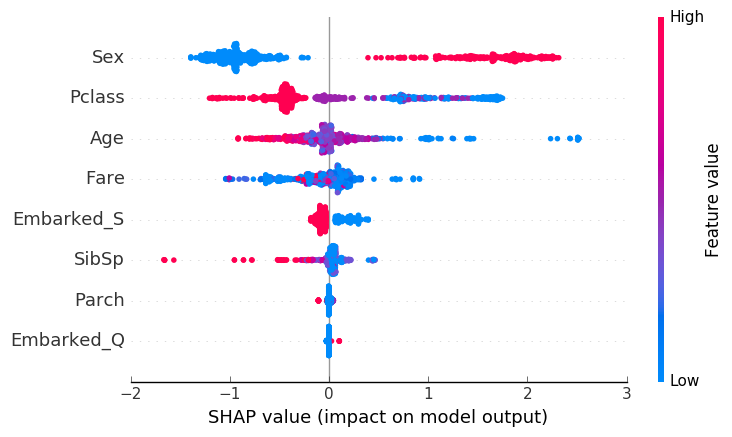

In [42]:
shap_values = shap_values_train
shap.summary_plot(shap_values, X_train, show = False)
# plt.savefig('SHAPSummary_XGB.png', bbox_inches="tight")

In [33]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

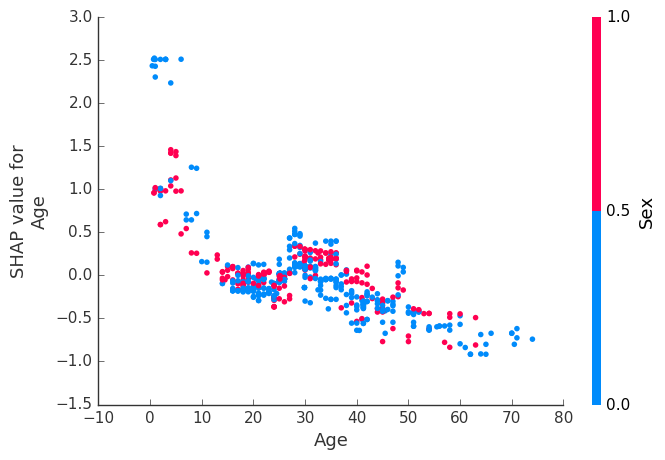

In [43]:
shap.dependence_plot("Age", shap_values, X_train, show = False)
# plt.savefig('SHAPAge_XGB.png', bbox_inches="tight")

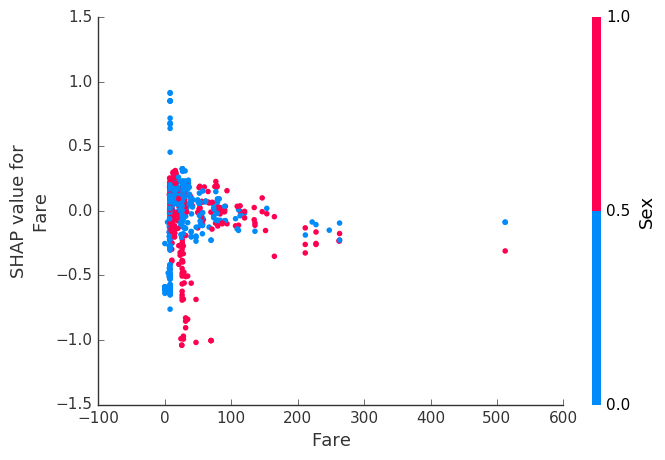

In [35]:
shap.dependence_plot("Fare", shap_values, X_train)

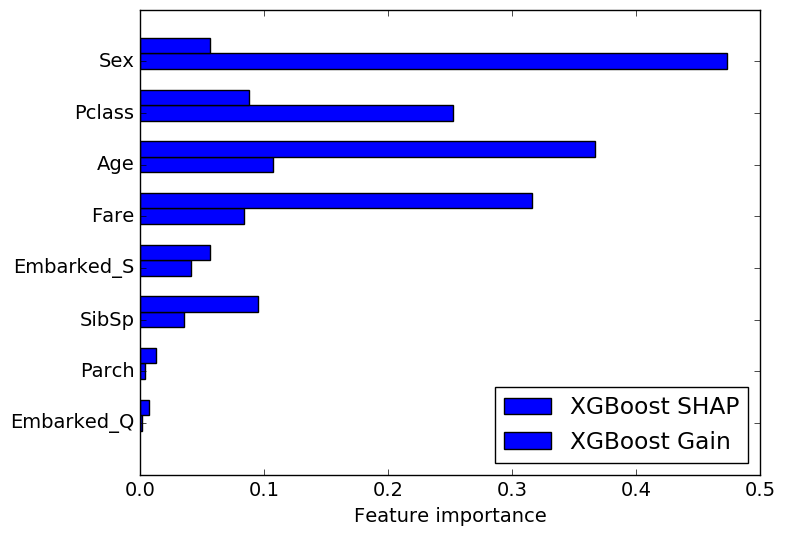

In [44]:
rcParams['font.size'] = 14
feature_names = X_train.columns.values
n_features = len(feature_names)
shap_per_feature = np.mean(np.abs(shap_values), axis = 0)
shap_per_feature = shap_per_feature/(np.sum(shap_per_feature))
idx_sorted = shap_per_feature.argsort()
fig = plt.figure(figsize=(8, 6)) 
plt.barh(np.arange(n_features) - 0.15, shap_per_feature[idx_sorted], 0.3)
plt.barh(np.arange(n_features) + 0.15, xgb.feature_importances_[idx_sorted], 0.3)
plt.xlabel("Feature importance")
plt.yticks(np.arange(n_features), feature_names[idx_sorted])
plt.legend(['XGBoost SHAP','XGBoost Gain'], loc = 'lower right')
# plt.savefig('FeatureImportance_XGB.png', bbox_inches="tight")

In [37]:
shap_interaction_values = explainer.shap_interaction_values(X_train)

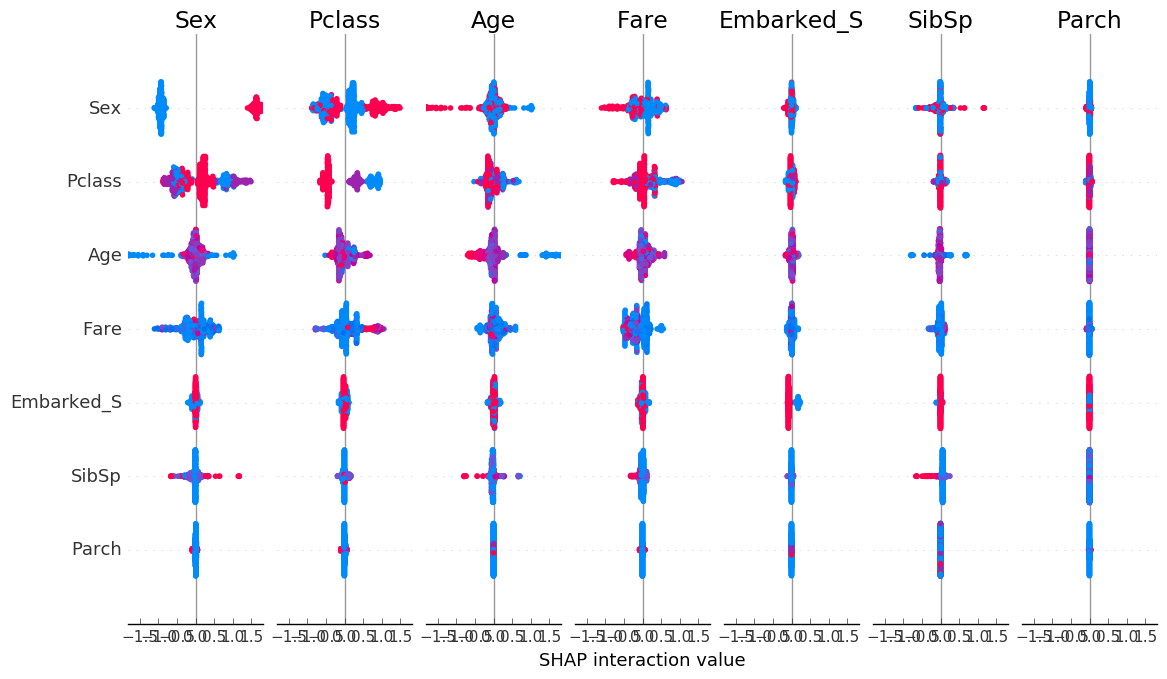

In [38]:
shap.summary_plot(shap_interaction_values, X_train)

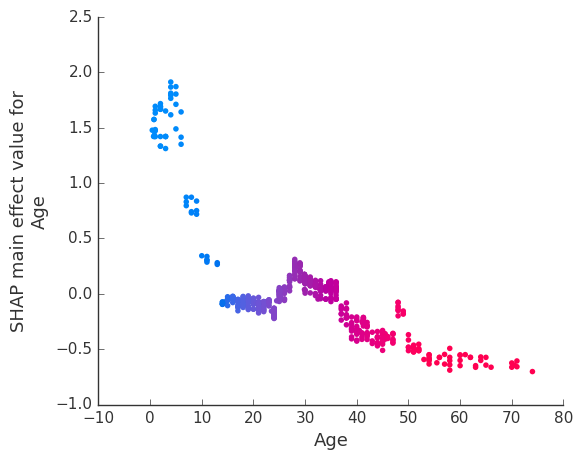

In [45]:
shap.dependence_plot(
    ("Age", "Age"),
    shap_interaction_values, X_train,
    display_features=X_train,
    show = False
)
# plt.savefig('SHAP_AgeMain_XGB.png', bbox_inches="tight")

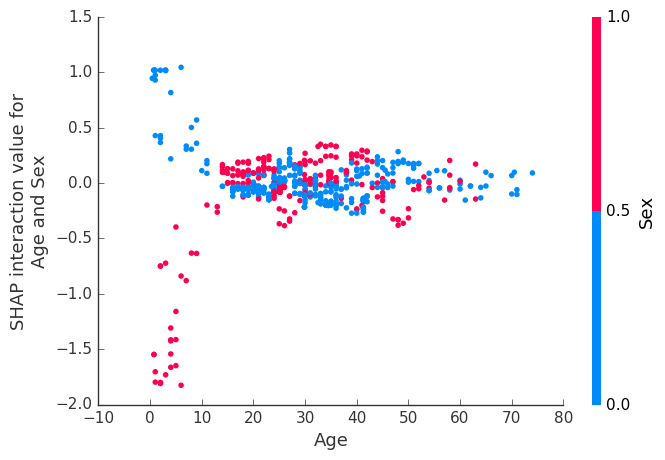

In [46]:
shap.dependence_plot(
    ("Age", "Sex"),
    shap_interaction_values, X_train,
    display_features=X_train,
    show = False
)
# plt.savefig('SHAP_AgeSex_XGB.png', bbox_inches="tight")

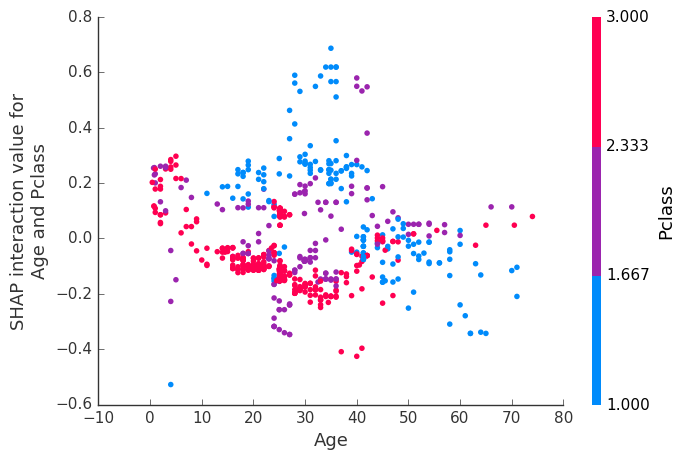

In [41]:
shap.dependence_plot(
    ("Age", "Pclass"),
    shap_interaction_values, X_train,
    display_features=X_train,
)